In [1]:
"""
@author: albertigno

"""

from DatasetLoader import *
import torch, time, os
import torch.nn as nn
import torch.nn.functional as F
#import networkx as nx
import matplotlib.pyplot as plt
#from matplotlib.gridspec import GridSpec

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
print ('Running on: {}'.format(device))

dataset = 'nmnist'
dataset_path = r'./../../datasets'
thresh = 0.3

if dataset == 'shd':
    batch_size = 256 # default 256
    learning_rate = 1e-4 # default 1e-4
    time_window = 50 # shd 50, nmnist 25-30
    #time_window = 100
    train_path = dataset_path+'/shd_digits/shd_train.h5'
    test_path = dataset_path+'/shd_digits/shd_test.h5'
else:
    batch_size = 200 
    learning_rate = 1e-4
    time_window = 25     
    train_path = dataset_path+'/nmnist/nmnist_train.mat'
    test_path = dataset_path+'/nmnist/nmnist_test.mat'           

Running on: cuda:0


In [10]:
from snn_models_monitor import *
%load_ext autoreload
%autoreload 1
%aimport snn_models_monitor

#tau_m = 'adp'
tau_m = 0.8305
#snn = RSNN_delay(d='shd', num_hidden=128, thresh=0.3, decay=0.3, batch_size=batch_size, win=50, device=device)
#snn = RSNN_monitor('shd', num_hidden=512, thresh=0.3, tau_m=tau_m, batch_size=batch_size, win=time_window, device=device)
snn = RSNN_monitor(dataset, num_hidden=256, thresh=0.3, tau_m=tau_m, batch_size=batch_size, win=time_window, device=device)
snn.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


RSNN_monitor(
  (fc_ih): Linear(in_features=2312, out_features=256, bias=False)
  (fc_hh): Linear(in_features=256, out_features=256, bias=False)
  (fc_ho): Linear(in_features=256, out_features=10, bias=False)
  (i_drop): Dropout(p=0.1, inplace=False)
)

<AxesSubplot:title={'center':'hidden-to-hidden weight distribution'}, xlabel='weight', ylabel='frequency'>

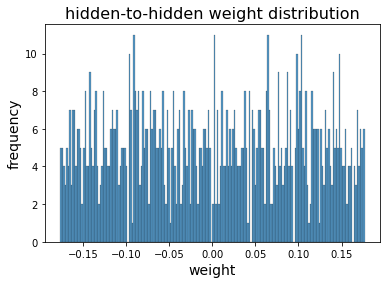

In [3]:
snn.plot_weights('hh')

In [3]:
# load datasets
print("loading test set...")
test_dataset = DatasetLoader(test_path, dataset, time_window, 'cpu')
print("loading training set...")
train_dataset = DatasetLoader(train_path, dataset, time_window, device)
print("loading data with pytorch")
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False, drop_last=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True, drop_last=True)

loading test set...
num sample: 10000
torch.Size([10000, 25, 2312]) torch.Size([10000, 10])
loading training set...
num sample: 60000
torch.Size([60000, 25, 2312]) torch.Size([60000, 10])
loading data with pytorch


[519.0, 110.765625]


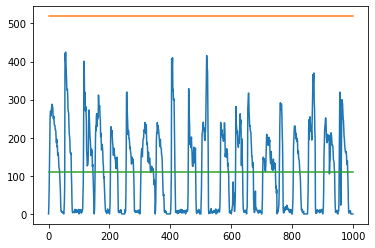

In [5]:
# check density of input spikes 
input_spike = test_dataset.images.reshape(-1, test_dataset.images.shape[-1]).sum(axis=1).cpu().numpy()
print([input_spike.max(), input_spike.mean()])
i_s = input_spike[:1000]
t = len(i_s)
plt.figure()
plt.plot(i_s)
plt.plot(np.arange(t), input_spike.max()*np.ones(t))
plt.plot(np.arange(t), input_spike.mean()*np.ones(t))
plt.show()

In [11]:
# training configuration

num_epochs = 20
modelname = dataset+'_rnn_{}.t7'.format(snn.num_hidden, tau_m)
num_samples = train_dataset.images.size()[0]

#optimizer = torch.optim.Adam(snn.parameters(), lr=learning_rate)

# set different learning rates
base_params = [snn.fc_ih.weight,
               snn.fc_hh.weight,
               snn.fc_ho.weight, 
               ]
if tau_m=='adp':
    print('tau_m_h ')
    optimizer = torch.optim.Adam([
        {'params': base_params},
        {'params': snn.tau_m_h, 'lr': learning_rate * 10.0}],
        lr=learning_rate)
else:    
    optimizer = torch.optim.Adam([
        {'params': base_params}],
        lr=learning_rate)
    
act_fun = ActFun.apply
print(modelname)

nmnist_rnn_256.t7


C:\Users\saucedo\anaconda3\envs\deeplearnig\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice.


In [12]:
# training loop
taus_m = []
for epoch in range(num_epochs):
    print('Epoch [%d/%d]'  % (epoch + 1, num_epochs))
    start_time = time.time()
    snn.train_step(train_loader, optimizer=optimizer, criterion=nn.MSELoss(), num_samples = num_samples, spkreg=0.01)
    print('Time elasped:', time.time() - start_time)
    
    # update learning rate
    optimizer = snn.lr_scheduler(optimizer, lr_decay_epoch=1)
    
    # weight and decay recording
    taus_m.append((snn.tau_m_h.data.detach().clone(), snn.tau_m_o.data.detach().clone()))
    
    if (epoch + 1) % 5 == 0:
        snn.test(test_loader, criterion=nn.MSELoss())
        snn.save_model(modelname)   

Epoch [1/20]
Step [100/300], Loss: 5.78861
Step [200/300], Loss: 2.64811
Step [300/300], Loss: 2.09922
Time elasped: 13.26176929473877
Epoch [2/20]
Step [100/300], Loss: 1.81404
Step [200/300], Loss: 1.65339
Step [300/300], Loss: 1.58169
Time elasped: 13.022860765457153
Epoch [3/20]
Step [100/300], Loss: 1.41759
Step [200/300], Loss: 1.38674
Step [300/300], Loss: 1.31979
Time elasped: 12.588993072509766
Epoch [4/20]
Step [100/300], Loss: 1.22815
Step [200/300], Loss: 1.19464
Step [300/300], Loss: 1.19408
Time elasped: 12.639090299606323
Epoch [5/20]
Step [100/300], Loss: 1.12218
Step [200/300], Loss: 1.08187
Step [300/300], Loss: 1.07919
Time elasped: 12.898468732833862
avg spk_count per neuron for all 25 timesteps 4.705173492431641
Test Accuracy of the model on the test samples: 96.250
Epoch [6/20]
Step [100/300], Loss: 0.98860
Step [200/300], Loss: 1.00642
Step [300/300], Loss: 0.98195
Time elasped: 13.118477821350098
Epoch [7/20]
Step [100/300], Loss: 0.96204
Step [200/300], Loss: 0

In [13]:
snn.save_to_numpy(modelname[:-3])

avg spk_count per neuron for all 25 timesteps 3.9259181022644043
Test Accuracy of the model on the test samples: 97.240


<IPython.core.display.Javascript object>


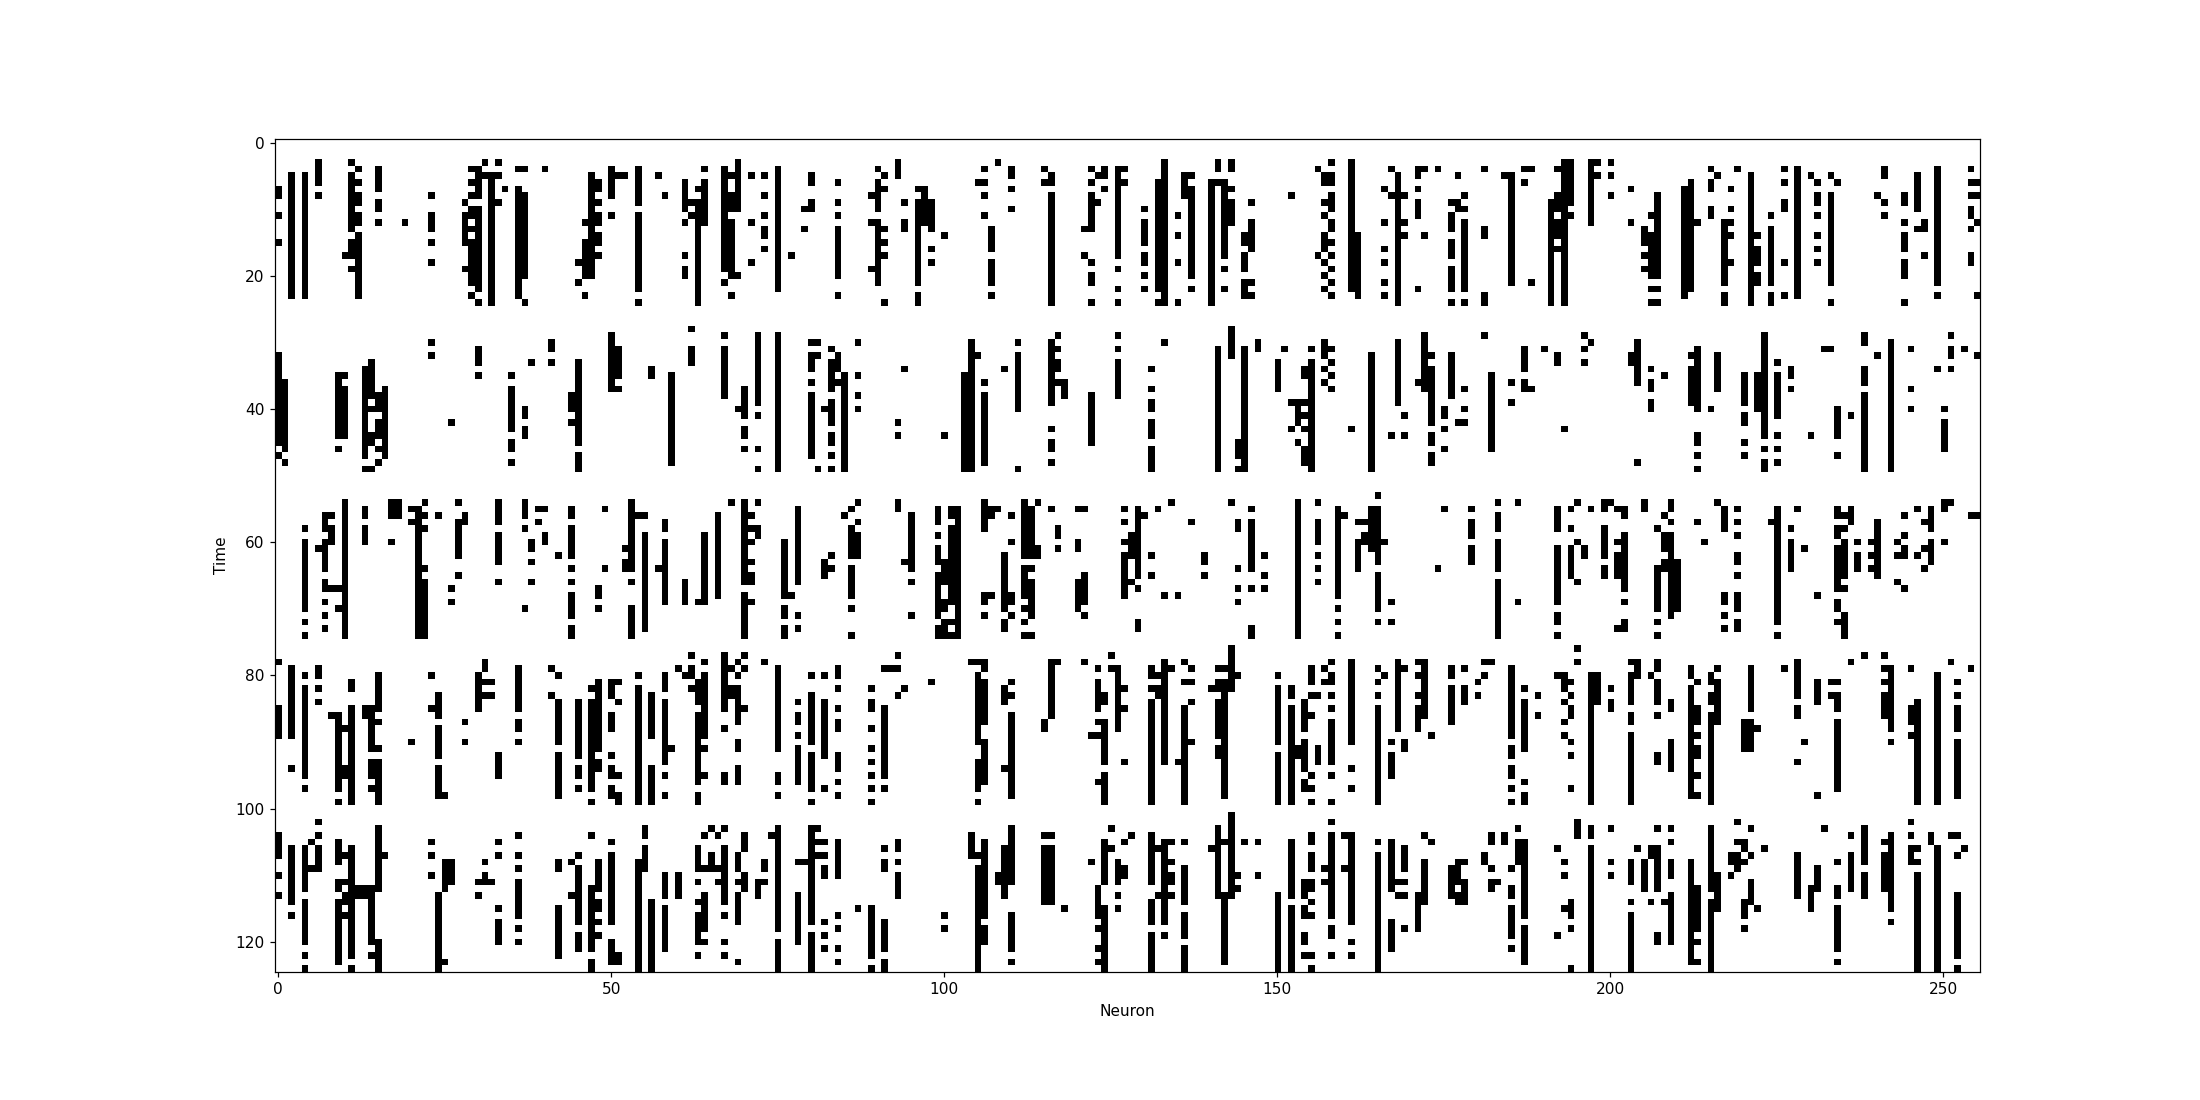

In [14]:
snn.test(test_loader, criterion=nn.MSELoss())
fig = snn.plot_activity('h','spike','normal', [0,1,2,3,4])

<IPython.core.display.Javascript object>


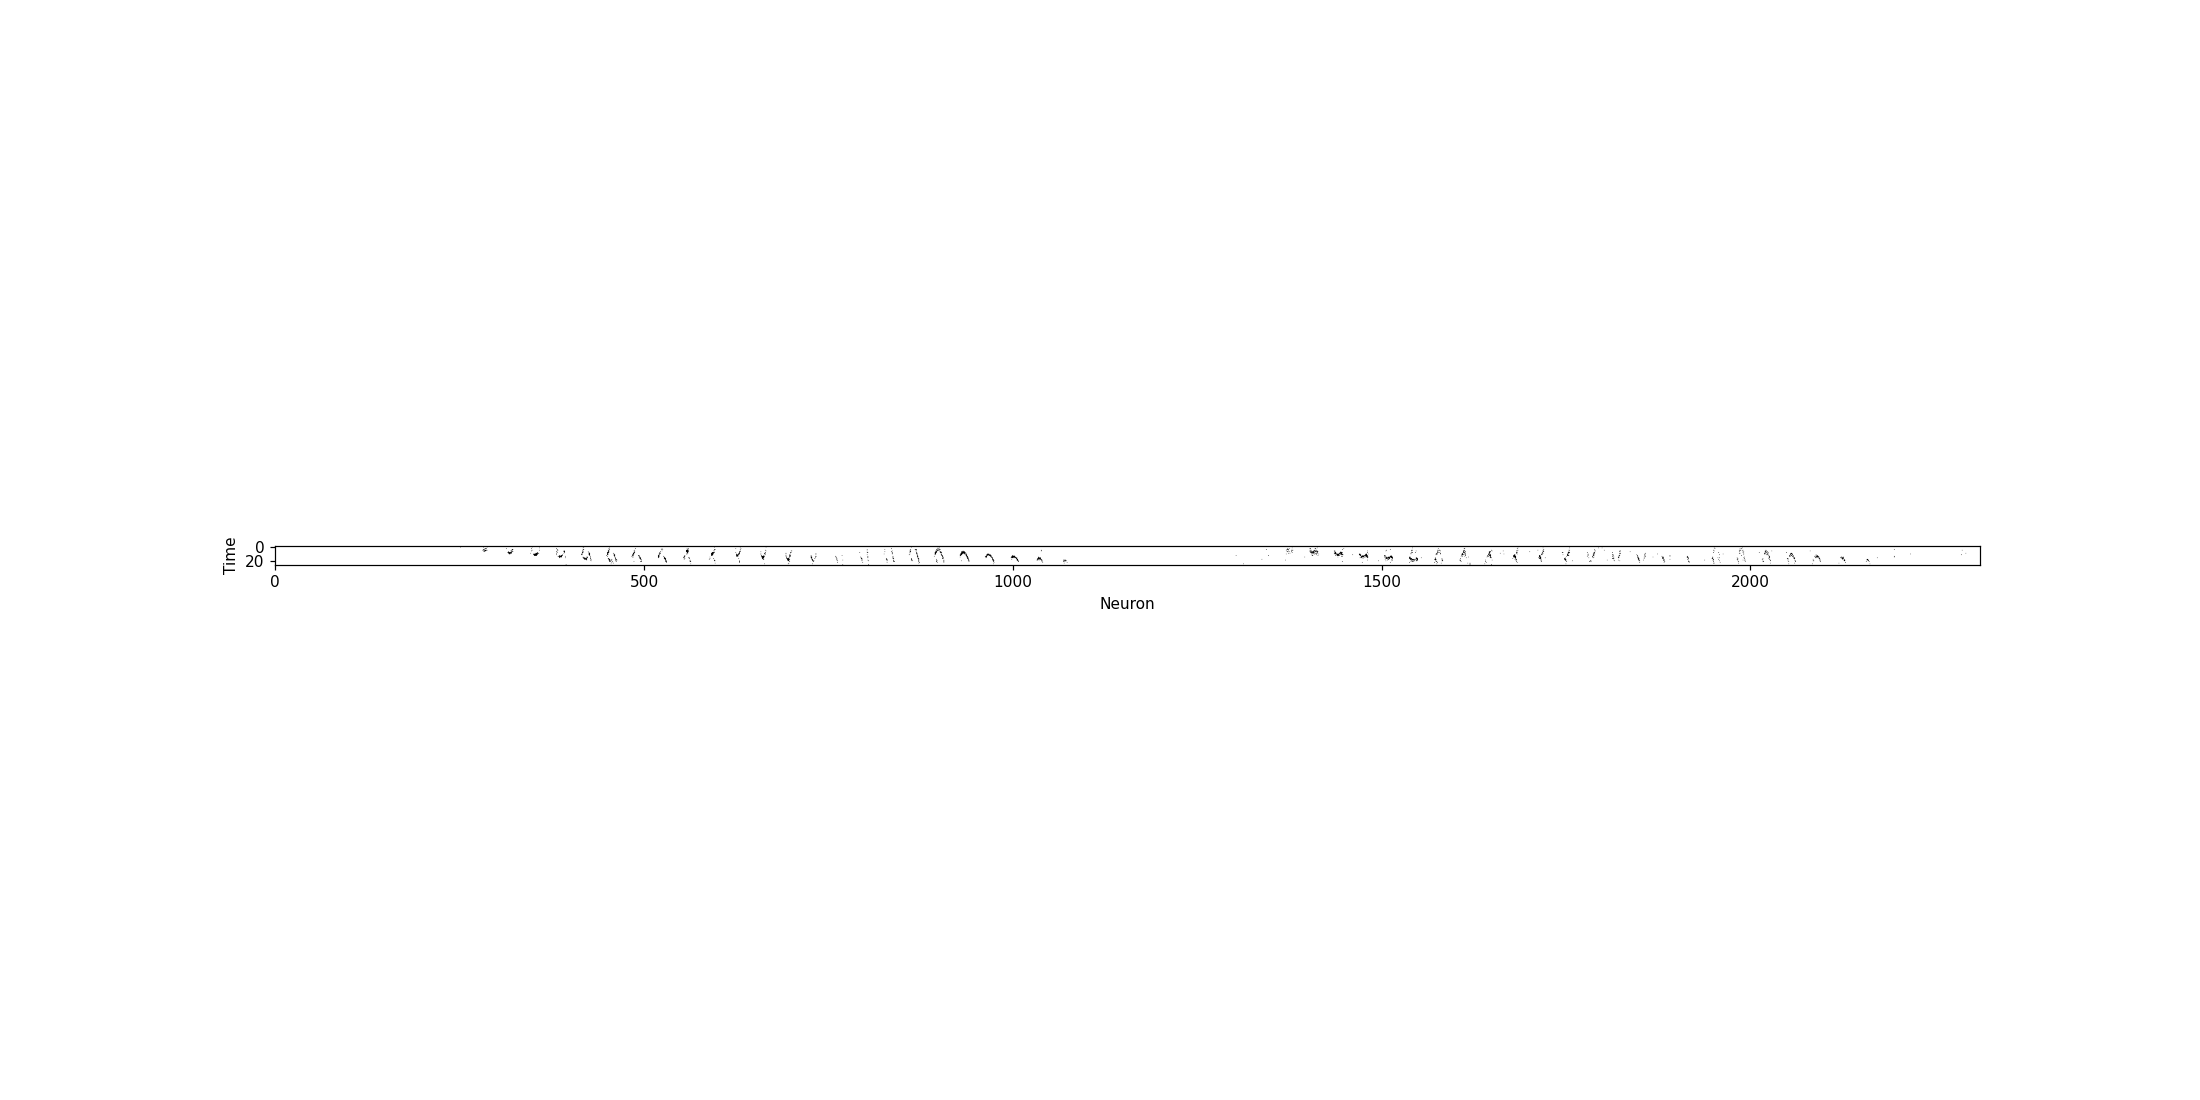

In [15]:
fig = snn.plot_activity('x','spike','normal', range(1))

[0, 1, 2]
[0, 1]
torch.Size([50, 256, 256])
torch.Size([3, 100])


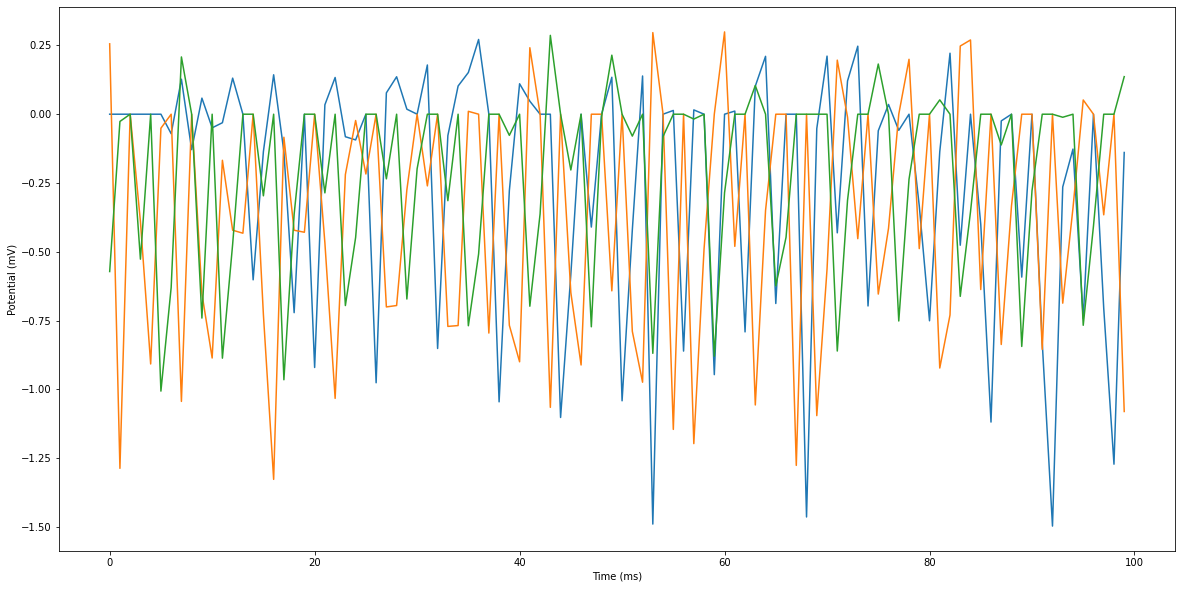

In [13]:
# neuron_id -> id of neurons to display
# sample_id -> id of sample to display
fig = snn.plot_mem('h', neuron_id =[0, 1, 2], sample_id = [0,1])

In [16]:
def square(num):
    '''
    get two closest factors of num so we can plot a vector of length num as an square-ish matrix
    '''
    factor1 = [x for x in range(1,num+1) if num%x==0 ]
    factor2 = [int(num/x) for x in factor1]
    idx = np.argmin(np.abs(np.array(factor2) - np.array(factor1)))
    return factor1[idx], factor2[idx]

<IPython.core.display.Javascript object>


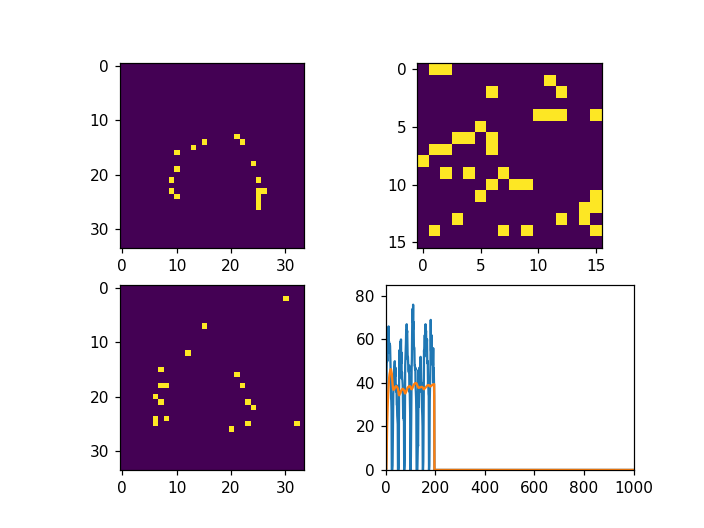

In [17]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation

xh, yh = square(snn.num_hidden)

hidden_spk = snn.all_h_spike.permute(1,0,2).flatten(0,1).view(-1, xh, yh).detach().cpu().numpy()

output_spk = snn.all_o_spike.view(-1,snn.num_output).detach().cpu().numpy()

num_channels = 2

ni = int(snn.num_input / num_channels)
xx, yx = square(ni)

hidden_spk[0,0,0] = 1.0

fig = plt.figure()

gs = fig.add_gridspec(2,2)

if num_channels==1:
    ax1 = fig.add_subplot(gs[:, 0])
    x_spk = snn.all_x.permute(1,0,2).flatten(0,1).view(-1, xx, yx).detach().cpu().numpy()
    x_spk[0,0,0] = 1.0
    im_x = ax1.imshow(x_spk[0,:,:])
elif num_channels ==2:
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    
    x_spk_1 = snn.all_x.permute(1,0,2).flatten(0,1)[:,:ni].view(-1, xx, yx).detach().cpu().numpy()
    x_spk_2 = snn.all_x.permute(1,0,2).flatten(0,1)[:,ni:].view(-1, xx, yx).detach().cpu().numpy()
    #x_spk_1 = np.swapaxes(x_spk_1, 1,2)
    #x_spk_2 = np.swapaxes(x_spk_2, 1,2)
    

    x_spk_1[0,0,0] = 1.0 
    x_spk_2[0,0,0] = 1.0
    im_x_1 = ax1.imshow(x_spk_1[0,:,:])
    im_x_2 = ax2.imshow(x_spk_2[0,:,:])
    
ax3 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[1, 1])
#ax4 = fig.add_subplot(gs[0, 2])
#ax5 = fig.add_subplot(gs[1, 2])

im_h = ax3.imshow(hidden_spk[0,:,:])
ax4.set_xlim(0,1000)
ax4.set_ylim(0,int(snn.num_hidden/3))
spk, = ax4.plot([])
avg_spk, = ax4.plot([])

t = np.arange(1000)
spk_data = np.zeros(1000)
avg_spk_data = np.zeros(1000)



def animate(frame_num):
    
    spk_data[frame_num] = hidden_spk[frame_num,:,:].sum()
    avg_spk_data[frame_num] = spk_data[:frame_num].mean()
    
    if num_channels==1:
        im_x.set_data(x_spk[frame_num,:,:])
    else:
        im_x_1.set_data(x_spk_1[frame_num,:,:])
        im_x_2.set_data(x_spk_2[frame_num,:,:])
    im_h.set_data(hidden_spk[frame_num,:,:])
    spk.set_data((t, spk_data))
    avg_spk.set_data((t, avg_spk_data))
    #im_h1.set_data(hidden_spk[t,:,:])    
    #return (im_x, im_h)

anim = FuncAnimation(fig, animate, frames=1000, interval=10)
plt.show()

array([[[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [26]:
#tau_m = 'adp'
tau_m = 0.8305
#snn = RSNN_delay(d='shd', num_hidden=128, thresh=0.3, decay=0.3, batch_size=batch_size, win=50, device=device)
snn_r = RSNN_monitor('shd', num_hidden=1024, thresh=0.3, tau_m=tau_m, batch_size=batch_size, win=time_window, device=device)
snn_r.to(device)

# training configuration

num_epochs = 200
modelname = 'shd_rnn_{}r.t7'.format(snn_r.num_hidden, tau_m)
num_samples = train_dataset.images.size()[0]

#optimizer = torch.optim.Adam(snn.parameters(), lr=learning_rate)

# set different learning rates
base_params = [snn_r.fc_ih.weight,
               snn_r.fc_hh.weight,
               snn_r.fc_ho.weight, 
               ]
if tau_m=='adp':
    print('tau_m_h ')
    optimizer = torch.optim.Adam([
        {'params': base_params},
        {'params': snn_r.tau_m_h, 'lr': learning_rate * 10.0}],
        lr=learning_rate)
else:    
    optimizer = torch.optim.Adam([
        {'params': base_params}],
        lr=learning_rate)
    
act_fun = ActFun.apply
print(modelname)

for epoch in range(num_epochs):
    print('Epoch [%d/%d]'  % (epoch + 1, num_epochs))
    start_time = time.time()
    snn_r.train_step(train_loader, optimizer=optimizer, criterion=nn.MSELoss(), num_samples = num_samples, spkreg=0.1)
    print('Time elasped:', time.time() - start_time)
    
    # update learning rate
    optimizer = snn_r.lr_scheduler(optimizer, lr_decay_epoch=1)
    
    if (epoch + 1) % 5 == 0:
        snn_r.test(test_loader, criterion=nn.MSELoss())
        #snn.save_model(modelname)   

shd_rnn_1024r.t7
Epoch [1/200]
Step [10/31], Loss: 0.60189
Step [20/31], Loss: 0.54660
Step [30/31], Loss: 0.51844
Time elasped: 2.7563846111297607
Epoch [2/200]
Step [10/31], Loss: 0.49539
Step [20/31], Loss: 0.48228
Step [30/31], Loss: 0.46819
Time elasped: 2.673203945159912
Epoch [3/200]
Step [10/31], Loss: 0.45873
Step [20/31], Loss: 0.45072
Step [30/31], Loss: 0.44588
Time elasped: 2.592583179473877
Epoch [4/200]
Step [10/31], Loss: 0.43772
Step [20/31], Loss: 0.43200
Step [30/31], Loss: 0.42425
Time elasped: 2.6557092666625977
Epoch [5/200]
Step [10/31], Loss: 0.41733
Step [20/31], Loss: 0.41411
Step [30/31], Loss: 0.40517
Time elasped: 2.654700756072998
avg spk_count per neuron for all 50 timesteps 1.5575065612792969
Test Accuracy of the model on the test samples: 44.727
Epoch [6/200]
Step [10/31], Loss: 0.39103
Step [20/31], Loss: 0.38150
Step [30/31], Loss: 0.37790
Time elasped: 2.6790618896484375
Epoch [7/200]
Step [10/31], Loss: 0.36637
Step [20/31], Loss: 0.36491
Step [30/3

Step [20/31], Loss: 0.26029
Step [30/31], Loss: 0.24331
Time elasped: 2.6364214420318604
Epoch [55/200]
Step [10/31], Loss: 0.23338
Step [20/31], Loss: 0.23061
Step [30/31], Loss: 0.22783
Time elasped: 2.6092042922973633
avg spk_count per neuron for all 50 timesteps 3.5730133056640625
Test Accuracy of the model on the test samples: 62.695
Epoch [56/200]
Step [10/31], Loss: 0.22595
Step [20/31], Loss: 0.22702
Step [30/31], Loss: 0.24466
Time elasped: 2.620084524154663
Epoch [57/200]
Step [10/31], Loss: 0.23011
Step [20/31], Loss: 0.21518
Step [30/31], Loss: 0.22139
Time elasped: 2.6029210090637207
Epoch [58/200]
Step [10/31], Loss: 0.26911
Step [20/31], Loss: 0.24219
Step [30/31], Loss: 0.21617
Time elasped: 2.6091549396514893
Epoch [59/200]
Step [10/31], Loss: 0.20507
Step [20/31], Loss: 0.19436
Step [30/31], Loss: 0.20718
Time elasped: 2.5927536487579346
Epoch [60/200]
Step [10/31], Loss: 0.20794
Step [20/31], Loss: 0.19719
Step [30/31], Loss: 0.18953
Time elasped: 2.610466241836548
a

Step [10/31], Loss: 0.14129
Step [20/31], Loss: 0.14228
Step [30/31], Loss: 0.14325
Time elasped: 2.608208179473877
Epoch [108/200]
Step [10/31], Loss: 0.13891
Step [20/31], Loss: 0.14010
Step [30/31], Loss: 0.13891
Time elasped: 2.627357244491577
Epoch [109/200]
Step [10/31], Loss: 0.13918
Step [20/31], Loss: 0.13914
Step [30/31], Loss: 0.13689
Time elasped: 2.6010937690734863
Epoch [110/200]
Step [10/31], Loss: 0.14031
Step [20/31], Loss: 0.13993
Step [30/31], Loss: 0.13904
Time elasped: 2.6063714027404785
avg spk_count per neuron for all 50 timesteps 3.5379600524902344
Test Accuracy of the model on the test samples: 72.217
Epoch [111/200]
Step [10/31], Loss: 0.14003
Step [20/31], Loss: 0.14044
Step [30/31], Loss: 0.13560
Time elasped: 2.622777223587036
Epoch [112/200]
Step [10/31], Loss: 0.14126
Step [20/31], Loss: 0.13710
Step [30/31], Loss: 0.13807
Time elasped: 2.6097757816314697
Epoch [113/200]
Step [10/31], Loss: 0.13958
Step [20/31], Loss: 0.13832
Step [30/31], Loss: 0.13744
T

Step [10/31], Loss: 0.13051
Step [20/31], Loss: 0.12991
Step [30/31], Loss: 0.12781
Time elasped: 2.6021480560302734
avg spk_count per neuron for all 50 timesteps 3.369354248046875
Test Accuracy of the model on the test samples: 71.533
Epoch [161/200]
Step [10/31], Loss: 0.12721
Step [20/31], Loss: 0.12848
Step [30/31], Loss: 0.13155
Time elasped: 2.619460105895996
Epoch [162/200]
Step [10/31], Loss: 0.12737
Step [20/31], Loss: 0.12806
Step [30/31], Loss: 0.12989
Time elasped: 2.600832939147949
Epoch [163/200]
Step [10/31], Loss: 0.12681
Step [20/31], Loss: 0.12916
Step [30/31], Loss: 0.13244
Time elasped: 2.63728666305542
Epoch [164/200]
Step [10/31], Loss: 0.12724
Step [20/31], Loss: 0.12985
Step [30/31], Loss: 0.13022
Time elasped: 2.60935115814209
Epoch [165/200]
Step [10/31], Loss: 0.12957
Step [20/31], Loss: 0.12889
Step [30/31], Loss: 0.12815
Time elasped: 2.5934834480285645
avg spk_count per neuron for all 50 timesteps 3.408275604248047
Test Accuracy of the model on the test sa

In [27]:
snn_r.save_to_numpy(modelname[:-3])

In [ ]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

xh, yh = square(snn.num_hidden)
xx, yx = square(snn.num_input)

hidden_spk = snn.all_h_spike.permute(1,0,2).flatten(0,1).view(-1, xh, yh).detach().cpu().numpy()
hidden_spk_r = snn_r.all_h_spike.permute(1,0,2).flatten(0,1).view(-1, xh, yh).detach().cpu().numpy()

x_spk = snn.all_x.permute(1,0,2).flatten(0,1).view(-1, xx, yx).detach().cpu().numpy()
#output_spk = snn.all_o_spike.view(-1,snn.num_output).detach().cpu().numpy()

print(hidden_spk.sum())
print(hidden_spk_r.sum())

fig = plt.figure()

gs = fig.add_gridspec(2,3)

ax1 = fig.add_subplot(gs[:, 0])
x_spk = snn.all_x.permute(1,0,2).flatten(0,1).view(-1, xx, yx).detach().cpu().numpy()
x_spk[0,0,0] = 1.0
im_x = ax1.imshow(x_spk[0,:,:])
    
    
ax3 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[0, 2])
ax6 = fig.add_subplot(gs[1, 2])

im_h = ax3.imshow(hidden_spk[0,:,:])
ax4.set_xlim(0,1000)
ax4.set_ylim(0,int(snn.num_hidden/3))
spk, = ax4.plot([])
avg_spk, = ax4.plot([])

t = np.arange(1000)
spk_data = np.zeros(1000)
avg_spk_data = np.zeros(1000)

hidden_spk[0,0,0] = 1.0
hidden_spk_r[0,0,0] = 1.0


im_x = ax1.imshow(x_spk[0,:,:])
im_h = ax3.imshow(hidden_spk[0,:,:])     # A tuple unpacking to unpack the only plot

im_h_r = ax5.imshow(hidden_spk_r[0,:,:])     # A tuple unpacking to unpack the only plot

ax4.set_xlim(0,1000)
ax4.set_ylim(0,int(snn.num_hidden/2))

ax6.set_xlim(0,1000)
ax6.set_ylim(0,int(snn.num_hidden/2))

spk, = ax4.plot([])
avg_spk, = ax4.plot([])

spk_r, = ax6.plot([])
avg_spk_r, = ax6.plot([])

t = np.arange(1000)
spk_data = np.zeros(1000)
avg_spk_data = np.zeros(1000)
spk_data_r = np.zeros(1000)
avg_spk_data_r = np.zeros(1000)

#ax.set_xlim(0, 2*np.pi)
#ax.set_ylim(-1.1, 1.1)

def animate(frame_num):
    
    spk_data[frame_num] = hidden_spk[frame_num,:,:].sum()
    avg_spk_data[frame_num] = spk_data[:frame_num].mean()

    spk_data_r[frame_num] = hidden_spk_r[frame_num,:,:].sum()
    avg_spk_data_r[frame_num] = spk_data_r[:frame_num].mean()    
    
    im_x.set_data(x_spk[frame_num,:,:])
    im_h.set_data(hidden_spk[frame_num,:,:])
    im_h_r.set_data(hidden_spk_r[frame_num,:,:])
    spk.set_data((t, spk_data))
    avg_spk.set_data((t, avg_spk_data))
    spk_r.set_data((t, spk_data_r))
    avg_spk_r.set_data((t, avg_spk_data_r))    
    
    #im_h1.set_data(hidden_spk[t,:,:])    
    return (im_x, im_h)



anim = FuncAnimation(fig, animate, frames=1000, interval=10)
#anim.save('reg_effect.gif', writer = PillowWriter(fps=15))
plt.show()

In [ ]:
Dictionary1 = {'A': 'Geeks', 'B': 'For'}

In [ ]:
'A' in Dictionary1.keys()

In [ ]:
ax[0,0]

In [ ]:
plt.imshow(hidden_spk[25,:,:])

In [ ]:
snn.all_h_spike

In [ ]:

hidden_spk[25,:]

In [ ]:
hidden_spk.

In [ ]:
snn.all_h_spike[25,0,:]

In [ ]:
snn.all_h_spike[25,0,:].shape

In [ ]:
snn.all_h_spike.shape

#### Single neuron analysis

In [ ]:
from MyDataset import *

time_window = 50
batch_size = 1
#device = 'cuda:0'
device = device

dataset_path = r'./../../datasets'
test_path = dataset_path+'/shd_digits/shd_test.h5'

#test_dataset = MyDataset(test_path, 'hd_digits', time_window, device)

test_dataset = MyDataset(path ='1_20', method= 'random', win=time_window, device=device,num_samples = None)
test_dataset.images = torch.zeros(test_dataset.images.shape)

#test_dataset.images[0, 10, 5] = 1.0
#test_dataset.images[0, 11, 5] = 1.0
test_dataset.images[0, 12, 5] = 1.0
test_dataset.images[0, 12, 6] = 1.0
test_dataset.images[0, 2, 5] = 1.0
test_dataset.images[0, 20, 5] = 1.0

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False, drop_last=False)


In [ ]:
#tau_m = 'adp'
tau_m = 0.8305
#snn = RSNN_delay(d='shd', num_hidden=128, thresh=0.3, decay=0.3, batch_size=batch_size, win=50, device=device)
snn2 = RSNN_monitor('custom_20_10', num_hidden=10, thresh=0.3, tau_m=tau_m, batch_size=batch_size, win=time_window, device=device)
snn2.to(device)

In [ ]:
snn2.fc_ih.weight = torch.nn.Parameter(0.2*torch.ones(snn2.fc_ih.weight.shape, device=device))
snn2.fc_hh.weight = torch.nn.Parameter(0.0*torch.ones(snn2.fc_hh.weight.shape, device=device))
snn2.test(test_loader, criterion=nn.MSELoss())

In [ ]:
fig = snn2.plot_activity('x')

In [ ]:
fig = snn2.plot_activity('h')

In [ ]:
fig = snn2.plot_mem('h',[0])